In [2]:
#### read the  centromere region from centIER ####
library(dplyr)
Nip_cen_region_df <- read.csv("/public/home/cszx_huangxh/qiujie/collabrators/gulei/cen_analysis/cen_define_2.0/Nip/CentIER_final_results/Nip_genome.fa_centromere_range.txt",sep ="\t",header = FALSE)
Zpal_cen_region_df <- read.csv("/public/home/cszx_huangxh/qiujie/collabrators/gulei/cen_analysis/cen_define_2.0/Zpal/CentIER_final_results/Zpal_genome.fa_centromere_range.txt",sep ="\t",header = FALSE)
Nip_cen_region_df <- Nip_cen_region_df %>% mutate(Species='Nip') %>% select(Species,everything()) %>%
  mutate(V1=gsub("Chr([1-9])$","Chr0\\1",V1)) %>%
  rename(Chr=V1,CE_start=V2,CE_end=V3) 
Zpal_cen_region_df <- Zpal_cen_region_df %>% mutate(Species='Zpal') %>% select(Species,everything()) %>%
  mutate(V1=gsub("Chr([1-9])$","Chr0\\1",V1)) %>%
  rename(Chr=V1,CE_start=V2,CE_end=V3) 
combined_region_df <- bind_rows(Zpal_cen_region_df,Nip_cen_region_df)

#### read csv of chromosme length  ####  e.g Zpal,Chr01,109217070
Zpal_chr_length <- read.csv("/public/home/cszx_huangxh/qiujie/collabrators/gulei/genome_data/Zpal_chromosome_lengths.csv",sep = ",",header = FALSE)
Nip_chr_length <- read.csv("/public/home/cszx_huangxh/qiujie/collabrators/gulei/genome_data/Nip_chromosome_lengths.csv",sep = ",",header = FALSE)
colnames(Zpal_chr_length) <- c("Species","Chr","chr_length")
colnames(Nip_chr_length) <- c("Species","Chr","chr_length")
combined_chr_length <- bind_rows(Zpal_chr_length,Nip_chr_length)

### merge ###
combined_position_df <- merge(combined_chr_length,combined_region_df,by = c("Species", "Chr")) %>%
  mutate( CEN_length = CE_end- CE_start)


combined_position_df <- combined_position_df %>%
  mutate(P_ratio = CE_start / (chr_length - CE_end),
         N_ratio = (chr_length - CE_end) / CE_start,
         LS_ratio = pmax(P_ratio, N_ratio)) 
         
# combined_position_df 
write.table(combined_position_df,"combined_position.csv",row.names = TRUE,sep = "\t")

In [8]:
##### Read the TRASH results (using the -max.div 5 parameter to obtain the maximum divided monomer) ####
library(dplyr)
# read two CSV files
repeats_df_Zpal <- read.csv("/public/home/cszx_huangxh/qiujie/collabrators/gulei/cen_analysis/CenTools/cen/Zpal/Zpal_HOR/all.repeats.from.Zpal_genome.fa.csv")
repeats_df_Nip <- read.csv('/public/home/cszx_huangxh/qiujie/collabrators/gulei/cen_analysis/CenTools/cen/Nip/Nip_HOR/all.repeats.from.Nip_genome.fa.csv')

#### The TRASH software involves a secondary correction process, which is reflected in the allrepeats.csv file. ####
#### In some cases, two adjacent rows under the class column may display repeated entries, where the start/end coordinates of the previous row are identical or very close to those in the following row. ###
#### In such cases, the former entry should be removed, and the latter retained.）####
repeats_df_Zpal <- repeats_df_Zpal %>% mutate(Species='Zpal') %>% select(Species, everything()) %>% 
  rename(Chr=seq.name) %>%
  filter(!(abs(start - lead(start)) <= 5 | abs(end - lead(end)) <= 5))
 
repeats_df_Nip <- repeats_df_Nip %>% mutate(Species='Nip') %>% select(Species, everything()) %>% 
  rename(Chr=seq.name) %>%
  filter(!(abs(start - lead(start)) <= 5 | abs(end - lead(end)) <= 5))
Cent_df_Nip <- repeats_df_Nip %>% filter(width >= 140 & width <=170 & edit.distance <= 50  ) # & edit.distance <= 50
Cent_CE_df_Nip <- merge(Cent_df_Nip,combined_position_df,by = c("Species","Chr")) %>%
  select(Species,Chr,start,end,width,chr_length,CE_start,CE_end,CEN_length,class,edit.distance,strand,everything())


Cent_df_Zpal <- repeats_df_Zpal %>% filter(width >= 135 & width <=155 & edit.distance <= 50 ) # & edit.distance <= 50
Cent_CE_df_Zpal <- merge(Cent_df_Zpal,combined_position_df,by = c("Species","Chr")) %>%
  select(Species,Chr,start,end,width,chr_length,CE_start,CE_end,class,edit.distance,strand,everything())


combined_Cent_CE_df <- bind_rows(Cent_CE_df_Nip,Cent_CE_df_Zpal)
# Cent_CE_df_Zpal 




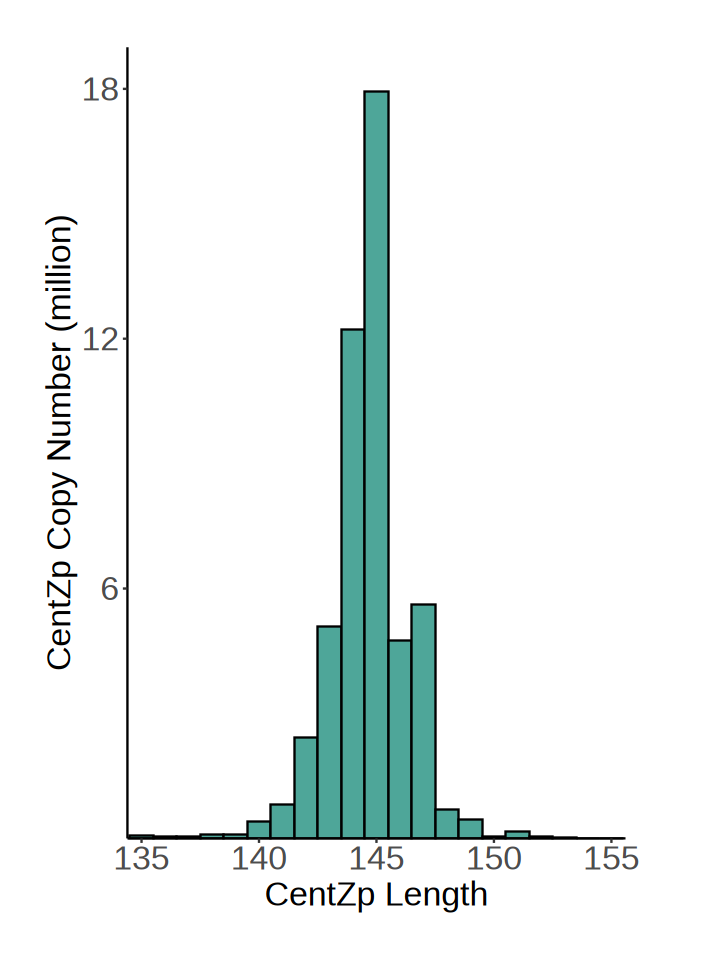

In [9]:
#### plot monomer max #### 
library(ggplot2)
library(dplyr)

Cent_width <- Cent_CE_df_Zpal %>%
  group_by(width) %>%
  summarise(total_width_sum = sum(width, na.rm = TRUE))

options(repr.plot.width = 6, repr.plot.height = 8)

p <- ggplot(Cent_width, aes(x = as.factor(width))) +
  geom_bar(aes(y = total_width_sum, fill = "Cent"), stat = "identity", width = 1, color = "black") +
  scale_fill_manual(values = c("Cent" = "#4EA699FF"), 
                    labels = c("CentZp")) +  # 更改图例文本，仅保留 CentZp
  scale_x_discrete(breaks = as.character(seq(135, 155, by = 5))) +  # 横坐标为整数宽度
  scale_y_continuous(labels = scales::label_number(scale = 1e-6),  # 纵坐标以百万为单位显示
                     breaks = seq(6e6, 1.8e7, by = 6e6), limits = c(0, 1.9e7), expand = c(0, 0)) +  # 延伸到20M并删除Y轴与X轴的空隙
  labs(x = 'CentZp Length', y = 'CentZp Copy Number (million)') +
  theme_classic() +
  theme(
    legend.position = "none",                # 移除图例
    legend.text = element_text(size = 24),  # 增大图例文本的字号
    axis.text = element_text(size = 20),    # 增大刻度文字大小
    axis.title = element_text(size = 20),   # 增大坐标轴标题
    legend.title = element_blank(),         # 去掉图例标题
    panel.grid = element_blank(),           # 移除背景网格线
    panel.border = element_blank(),          # 取消边框
    plot.margin = unit(c(1, 2, 1, 1), "cm"),# 为右边留出更多空间
  ) 

# 显示图形
p

# 导出图形到 SVG 文件
library(svglite)
ggsave("plots/cent_distribution.svg", plot = p, width = 6, height = 8, units = "in", device = "svg")

In [10]:
Cent_CE_df_Zpal
print(length(unique(Cent_CE_df_Zpal$seq)))
print(length(unique(Cent_CE_df_Nip$seq)))

Species,Chr,start,end,width,chr_length,CE_start,CE_end,class,edit.distance,strand,seq,region.name,repetitiveness,CEN_length,P_ratio,N_ratio,LS_ratio
<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
Zpal,Chr01,47116308,47116453,146,109217070,49200001,51200000,CEN144,31,+,GATAATTGGGCACATTTTTGAACTTTTTTGTTCCAGAAGCGAACTTTTTGATTCTTGTATGTTACAGTTGTCGTCTATGTCACCACATTCATGTCCGAAACAGAAACATTAGAAACACATCCTTTGTTACTATTACACCATATTAG,Zpal_genome.fa_Chr01,453,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47116454,47116596,143,109217070,49200001,51200000,CEN144,36,+,GATTACTAGGCACGATTTTAACCTTTTGTTCAAGAAGCGAAGTTTTCATTCTTGCAAGTTATGGGTGTCGTCTATTTTGCAAACTTTGTGTACGGATCGGAAATGCTAGAAACACTCACTTGGTACTTTTACACCATATTACG,Zpal_genome.fa_Chr01,1055,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47116597,47116740,144,109217070,49200001,51200000,CEN144,29,+,GTTATTTGGCACATTTTTGAACTTTTTTGTTCCGGATGCGAACTTTTGATTCTTGCATGTTATTGGTGCCGTCTATTTCACAACATTCGTGTTCGGAACGGAAACATTAGAAACACATACTTTGTTACTATTATACCATATTAG,Zpal_genome.fa_Chr01,1223,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47116741,47116884,144,109217070,49200001,51200000,CEN144,41,+,GATGATTGGACATGTTTATGATCCTTTTCATTCGAGAAGCGAAGTTTTAATCTTGCAAGTTAGGGCTGCTGTTTATTTCGCAAACTCTGTGTAAGGATCGAAAATTCTATAAACACTAACTTGCTACTTCTACACGATATTACG,Zpal_genome.fa_Chr01,1140,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47116885,47117029,145,109217070,49200001,51200000,CEN144,32,+,GTTATTTGGCACATTTTTGAACGTTTTTGTTCCGGGAGCAAACTTTTGATTCTTGCATGTTACGGGTGCCATCTATTTCACAACCATCGCTTTCCGGAACGGAAACGTTAGAAACACATCCTTTGTTATTATTACACCATATTAC,Zpal_genome.fa_Chr01,754,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47117030,47117173,144,109217070,49200001,51200000,CEN144,31,+,GCTGATTGGACATGTTTATGAACCTTTTTGTTCTGGAAGCGAAGTTTTACTCTTTCAAGTTATGGGTGTCGTCTATTTCGCAAACTTTGTGTATGGAATGGAAATGCTAGAAACACATCAGTTGGTAGTATTACACCATATTTC,Zpal_genome.fa_Chr01,857,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47117410,47117553,144,109217070,49200001,51200000,CEN144,28,+,GTTTATTTGTCACATTTTGAACTTTTTTGTTTCGGAAGCGAACTTTTGATTCTTGCATGTTACGGGTGTCGTCTATTTCACAACATTCGTGTACAGAACGAAAACGTTAGAAACACAACCTTTGTTACTATTACACCATATTAG,Zpal_genome.fa_Chr01,1192,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47117554,47117697,144,109217070,49200001,51200000,CEN144,33,+,GATGATTGGACATGTTTATGAACATTTTTGTTCCAGAAGCGAAGTTTTAATCTTATGAGTTACTGGTGTCGTCTATTTCGCAAACTTTCTGTACAGAACGGAAATGCTTGAAACACTCACTTGGTACTTCTACACCATATTACG,Zpal_genome.fa_Chr01,1134,1999999,0.8480263,1.179209,1.179209
Zpal,Chr01,47117698,47117840,143,109217070,49200001,51200000,CEN144,33,+,GTTATCTGGCACATTTTTGAACTTTTTTTTTCGAAAGCGAACTTTTGATTCTTGCATGTTATGGATGTCGTCTATTTCGCTACATTCGTGTCCGGAACGGAAACGATAGAAACACATCTTTTGTTACTATTACTTCATATTAT,Zpal_genome.fa_Chr01,403,1999999,0.8480263,1.179209,1.179209


[1] 167041
[1] 9089
